In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras

In [3]:
items = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/items.csv')
cats = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/shops.csv')
train = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/test.csv')

In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


파일설명
- sales_train.csv - 교육 세트. 2013년 1월부터 2015년 10월까지 일일 기록 데이터.
- test.csv - 테스트 세트. 2015년 11월 판매량을 예측해야 합니다.
- sample_submission.csv - 올바른 형식의 샘플 제출 파일입니다.
- items.csv - 항목/제품에 대한 추가 정보.
- item_categories.csv - 항목 카테고리에 대한 추가 정보.
- shops.csv- 상점들에 대한 보충 정보들.

데이터 필드
- ID - 테스트 세트 내의 (샵, 품목) 튜플을 나타내는 ID
- shop_id - 상점의 고유 식별자
- item_id - 제품의 고유 식별자
- item_suffer_id - 품목 범주의 고유 식별자
- item_cnt_day - 판매된 제품 수입니다. 이 조치의 월 금액을 예측하고 있습니다.
- item_price - 품목의 현재 가격
- date- 날짜(dd/mm/yyyy) 형식
- date_block_num - 편의상 사용되는 연속 월 번호입니다. 2013년 1월 = 0일, 2013년 2월 = 1,... 2015년 10월 = 33
- item_name - 항목 이름
- shop_name - 상점 이름
- item_suffer_name - 품목 카테고리 이름

In [12]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [13]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [14]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [16]:
#train['date'] = pd.to_datetime(train['date']) # date를 object 타입에서 datetime 으로 바꿔줌
train['date'] = pd.to_datetime(train['date']).dt.strftime('%Y-%m')

In [18]:
# dataset 을 만듦 / 피벗 테이블 생성
# 매장에 대한 한 아이템의 전체 개수 값을 가져온다.
# shop_id와 item_id를 인덱스로 하여 date_block_number 컬럼을 만듦
# item_cnt_day의 합을 위의 컬럼에 넣는다.

dataset = train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [19]:
dataset.reset_index(inplace = True)

In [22]:
dataset.describe

<bound method NDFrame.describe of                shop_id item_id item_cnt_day               ...                     
date_block_num                            0   1  2  3  4  ... 27 28 29 30 31 32 33
0                    0      30            0  31  0  0  0  ...  0  0  0  0  0  0  0
1                    0      31            0  11  0  0  0  ...  0  0  0  0  0  0  0
2                    0      32            6  10  0  0  0  ...  0  0  0  0  0  0  0
3                    0      33            3   3  0  0  0  ...  0  0  0  0  0  0  0
4                    0      35            1  14  0  0  0  ...  0  0  0  0  0  0  0
...                ...     ...          ...  .. .. .. ..  ... .. .. .. .. .. .. ..
424119              59   22154            1   0  0  0  0  ...  0  0  0  0  0  0  0
424120              59   22155            0   0  0  0  0  ...  0  0  0  0  0  0  0
424121              59   22162            0   0  0  0  0  ...  1  1  0  0  1  0  0
424122              59   22164            0   0  0  0

In [21]:
dataset.head()

shop_id item_id item_cnt_day               ...                     
date_block_num                            0   1  2  3  4  ... 27 28 29 30 31 32 33
0                    0      30            0  31  0  0  0  ...  0  0  0  0  0  0  0
1                    0      31            0  11  0  0  0  ...  0  0  0  0  0  0  0
2                    0      32            6  10  0  0  0  ...  0  0  0  0  0  0  0
3                    0      33            3   3  0  0  0  ...  0  0  0  0  0  0  0
4                    0      35            1  14  0  0  0  ...  0  0  0  0  0  0  0

[5 rows x 36 columns]

In [24]:
# 위에서 만든 피벗 테이블을 test와 머지

dataset = pd.merge(test,dataset,on = ['item_id','shop_id'],how = 'left')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [25]:
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# NaN 값은 0 으로
dataset.fillna(0, inplace=True)

In [31]:
dataset.describe

<bound method NDFrame.describe of             ID  shop_id  ...  (item_cnt_day, 32)  (item_cnt_day, 33)
0            0        5  ...                 1.0                 0.0
1            1        5  ...                 0.0                 0.0
2            2        5  ...                 3.0                 1.0
3            3        5  ...                 0.0                 0.0
4            4        5  ...                 0.0                 0.0
...        ...      ...  ...                 ...                 ...
214195  214195       45  ...                 0.0                 1.0
214196  214196       45  ...                 0.0                 0.0
214197  214197       45  ...                 0.0                 0.0
214198  214198       45  ...                 0.0                 0.0
214199  214199       45  ...                 0.0                 0.0

[214200 rows x 37 columns]>

In [27]:
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


모델링

In [33]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [29]:
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
y_train = dataset.values[:,-1:]
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 36, 1) (214200, 1) (214200, 36, 1)


In [34]:
# 모델링 정의 
model_lstm = Sequential()
model_lstm.add(LSTM(units = 128,input_shape = (X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 128,epochs = 15)

Epoch 1/10
3347/3347 [==============================] - 73s 22ms/step - loss: 29.3261 - mean_squared_error: 29.3261
Epoch 2/10
3347/3347 [==============================] - 75s 22ms/step - loss: 29.1683 - mean_squared_error: 29.1683
Epoch 3/10
3347/3347 [==============================] - 76s 23ms/step - loss: 29.0438 - mean_squared_error: 29.0438
Epoch 4/10
3347/3347 [==============================] - 75s 22ms/step - loss: 28.9737 - mean_squared_error: 28.9737
Epoch 5/10
3347/3347 [==============================] - 75s 22ms/step - loss: 28.7267 - mean_squared_error: 28.7267
Epoch 6/10
3347/3347 [==============================] - 76s 23ms/step - loss: 28.5438 - mean_squared_error: 28.5438
Epoch 7/10
3347/3347 [==============================] - 76s 23ms/step - loss: 28.4560 - mean_squared_error: 28.4560
Epoch 8/10
3347/3347 [==============================] - 77s 23ms/step - loss: 28.4106 - mean_squared_error: 28.4106
Epoch 9/10
3347/3347 [==============================] - 77s 23ms/step - 

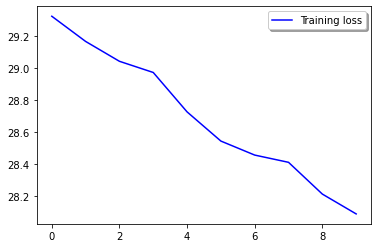

In [38]:
# loss 손실율 plot
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [43]:
submission_csv = model_lstm.predict(X_test)
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_csv.ravel()})

In [45]:
submission

,ID,item_cnt_month
0,0,0.541773
1,1,0.107733
2,2,0.861574
3,3,0.178307
4,4,0.107733
...,...,...
214195,214195,0.342045
214196,214196,0.107807
214197,214197,0.115401
214198,214198,0.107807


In [46]:
submission.to_csv('submission_csv.csv', index=False)

In [40]:
sample_submission = pd.read_csv('/content/drive/MyDrive/dataset/competitive-data-science-predict-future-sales/sample_submission.csv')

In [41]:
sample_submission

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5
